# **Nutrivision - Deep Learning Project**

---------------------------------------

**Goal:**

Create a model that will recognize food items and output the average calories per serving, use database https://www.kaggle.com/datasets/bjoernjostein/food-classification that contains 2 folders of images, one for training and the other one for testing, it also has 1 csv file containing the 61 labels and the labels Ids. csv file "foodcalories.csv" (path: /content/foodcalories.csv) has the 61 labels with the estimated calories.

-------------------------------------------

## **Step 1: Loading, Examining, Merging, and Preprocessing the Data**

We can start by importing all necessary libraries for this step


In [ ]:
import pandas as pd
import kagglehub
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### A. Download the Dataset

Download the latest version of our Kaggle-sourced dataset and create the 'path' variable, and then print the path so we know where to find our files

In [ ]:
path = kagglehub.dataset_download("bjoernjostein/food-classification")
print("Path to dataset files:", path)

100%|██████████| 753M/753M [00:09<00:00, 86.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bjoernjostein/food-classification/versions/2


Okay, now that we have our dataset downloaded, let's list the contents of the dataset folder, as well as the subitems within each folder item. If an item has no subitems, we can print 'None'. If an item has 2 or more subitems, we can just print the number of subitems instead of listing them all to avoid confusion. This will give us a clear idea of what the dataset folder structure is.

In [ ]:
folder_contents = os.listdir(path)
print("Contents of dataset folder:")
for item in folder_contents:
    print(item)
    if os.path.isdir(os.path.join(path, item)):
        subitems = os.listdir(os.path.join(path, item))
        subitem_count = len(subitems)
        if subitem_count < 2:
            for subitem in subitems:
                print("   ",subitem)
                subitem_path = os.path.join(path, item, subitem)
                if os.path.isdir(subitem_path):
                    sub_subitems_count = len(os.listdir(subitem_path))
                    print(f"       Number of sub-subitems: {sub_subitems_count}")
        else:
            print(f"Number of subitems: {subitem_count}")
    else:
        print("    None")

Contents of dataset folder:
train_img.csv
    None
train_images
    train_images
       Number of sub-subitems: 9323
test_images
    test_images
       Number of sub-subitems: 484


Great, so this tells us that our dataset folder has 3 items inside. One of these items is a CSV file. The other 2 items are folders that each contain another folder of the same name.

Within these folders are the items which we can assume are images that have aleady been broken into training and testing sets. However, since we would like to compare the predicted classes with the actual classes of each test item at the end, we will actually NOT be using the pre-established test set. Instead, we will split the original training set into a train and test set, as these items have already been accurately classified.

#### B. Load the CSV and Image Files

With that, let's load the CSV file found in the database into a pandas DataFrame, and then show the first few rows

In [ ]:
dataset_csv = '/root/.cache/kagglehub/datasets/bjoernjostein/food-classification/versions/2/train_img.csv'
training_image_label_data = pd.read_csv(dataset_csv)
print(training_image_label_data.head())
print("\nNumber of total training images identified: ",len(training_image_label_data))

          ImageId               ClassName
0  f27632d7e5.jpg                   water
1  efa87919ed.jpg  pizza-margherita-baked
2  4f169e8c8d.jpg                broccoli
3  a6956654bf.jpg  salad-leaf-salad-green
4  d99ce8c3bf.jpg                     egg

Number of total training images identified:  9323


Okay, this matches up with the number of training photos we have. And just how many unique ClassNames are there, and what are they? Let's find out, so we can see which foods we are trying to identify.

In [ ]:
unique_class_names = training_image_label_data['ClassName'].unique()
print("Unique values in 'ClassName' column:\n")
print(unique_class_names)
print(f"\nNumber of unique values: {len(unique_class_names)}")

Unique values in 'ClassName' column:

['water' 'pizza-margherita-baked' 'broccoli' 'salad-leaf-salad-green'
 'egg' 'butter' 'bread-white' 'apple' 'dark-chocolate'
 'white-coffee-with-caffeine' 'sweet-pepper'
 'mixed-salad-chopped-without-sauce' 'tomato-sauce' 'cucumber' 'cheese'
 'pasta-spaghetti' 'rice' 'zucchini' 'salmon' 'mixed-vegetables'
 'espresso-with-caffeine' 'banana' 'strawberries' 'mayonnaise' 'almonds'
 'bread-wholemeal' 'wine-white' 'hard-cheese' 'ham-raw' 'tomato'
 'french-beans' 'mandarine' 'wine-red' 'potatoes-steamed' 'croissant'
 'carrot' 'salami' 'boisson-au-glucose-50g' 'biscuits' 'corn'
 'leaf-spinach' 'tea-green' 'chips-french-fries' 'parmesan' 'beer'
 'bread-french-white-flour' 'coffee-with-caffeine' 'chicken' 'soft-cheese'
 'tea' 'avocado' 'bread-sourdough' 'gruyere' 'sauce-savoury' 'honey'
 'mixed-nuts' 'jam' 'bread-whole-wheat' 'water-mineral' 'onion' 'pickle']

Number of unique values: 61


Now load the caloric data CSV file into a pandas DataFrame, and then show the first few rows.

In [ ]:
calorie_csv = 'foodcalories.csv'
calorie_data = pd.read_csv(calorie_csv)
print(calorie_data.head())

                ClassName Estimated_Serving_Size  Calories_per_Serving
0                   water         1 cup (240 ml)                     0
1  pizza-margherita-baked        1 slice (120 g)                   300
2                broccoli           1 cup (91 g)                    31
3  salad-leaf-salad-green           1 cup (20 g)                     3
4                     egg         1 large (50 g)                    78


Okay, now that we have loaded our two CSV files, let's merge them to make the caloric data easier to align with each image. Then we can take a look at what we did!

In [ ]:
merged_data = pd.merge(training_image_label_data, calorie_data, on='ClassName')
print(merged_data.head())

          ImageId               ClassName Estimated_Serving_Size  \
0  f27632d7e5.jpg                   water         1 cup (240 ml)   
1  efa87919ed.jpg  pizza-margherita-baked        1 slice (120 g)   
2  4f169e8c8d.jpg                broccoli           1 cup (91 g)   
3  a6956654bf.jpg  salad-leaf-salad-green           1 cup (20 g)   
4  d99ce8c3bf.jpg                     egg         1 large (50 g)   

   Calories_per_Serving  
0                     0  
1                   300  
2                    31  
3                     3  
4                    78  


Great! Now that we have both of our CSV files set, let's visualize our training images folder by requesting the first 5 images and their file names.

Images found: ['b4a9fe253b.jpg', '3755012e4c.jpg', '5b05f84553.jpg', 'a50eba2206.jpg', '5c3f5246e4.jpg']


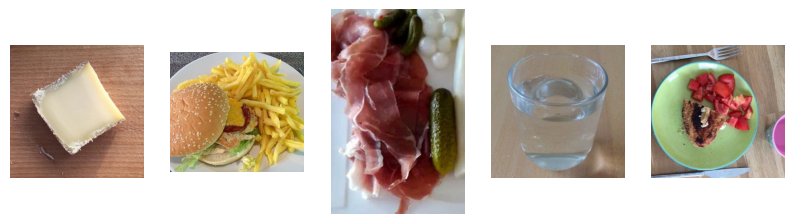

In [ ]:
org_training_images_folder = '/root/.cache/kagglehub/datasets/bjoernjostein/food-classification/versions/2/train_images/train_images'
training_images_files = [f for f in os.listdir(org_training_images_folder) if f.endswith('.jpg')][:5]
print("Images found:", training_images_files)
plt.figure(figsize=(10, 10))
for i, image_file in enumerate(training_images_files):
    image_path = os.path.join(org_training_images_folder, image_file)
    image = Image.open(image_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

#### C. Split the Data

Now it is time to split our original training set in order to create a new train and test set as previously discussed.

To split the merged_data DataFrame into training and testing sets, you can use the train_test_split function from scikit-learn. This function allows you to specify the size of the test set and randomly splits the data.

The original test set had 484 images, so let's aim for a similar test size.

In [ ]:
train_data, test_data = train_test_split(merged_data, test_size=0.05, random_state=42, stratify=merged_data['ClassName'])
print("Training Set Size:", len(train_data))
print("Testing Set Size:", len(test_data))

Training Set Size: 8856
Testing Set Size: 467


Our merged CSV data is now split to our liking, so let's split the images the same way, according to their file names!

Before we can do that, we need to create new paths to new folders within the original Dataset path to hold the newly split images.

In [ ]:
training_images_folder = '/root/.cache/kagglehub/datasets/bjoernjostein/food-classification/versions/2/training_images_folder'
testing_images_folder = '/root/.cache/kagglehub/datasets/bjoernjostein/food-classification/versions/2/testing_images_folder'
os.makedirs(training_images_folder, exist_ok=True)
os.makedirs(testing_images_folder, exist_ok=True)

And now we can preform the image split based on the data split

In [ ]:
def split_images(data, source_folder, destination_folder):
    for image_id in data['ImageId']:
        src_image_path = os.path.join(source_folder, image_id)
        dst_image_path = os.path.join(destination_folder, image_id)
        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dst_image_path)
        else:
            print(f"Image {image_id} not found in {source_folder}")
split_images(train_data, org_training_images_folder, training_images_folder)
split_images(test_data, org_training_images_folder, testing_images_folder)

#### D. Preprocess the Training Images

Okay, now let's augment and preprocess the images to prepare them for use in a deep learning model. CNNs typically expect images to all be the same size, so we will need to resize them to make sure. Then we can create the training and validation generators that our model will use to train.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(
    merged_data,
    directory=training_images_folder,
    x_col='ImageId',
    y_col='ClassName',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training')
validation_generator = train_datagen.flow_from_dataframe(
    merged_data,
    directory=training_images_folder,
    x_col='ImageId',
    y_col='ClassName',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation')

Found 7085 validated image filenames belonging to 61 classes.
Found 1771 validated image filenames belonging to 61 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 467 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 467 invalid image filename(s) in x_col="ImageId". These filename(s) will be ignored.
  warnings.warn(


Wonderful, now all of our data has been loaded and examined! Let's move onto the next step.

## **Step 2: Building and Training the Model**

Here we will use transfer learning, loading a pre-trained model and fine-tuning it for the classification task.

Let's start by importing the libraries we will need for this step.

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

#### A. Load the Pre-Trained Model


Now we can load the pre-trained model, in this case MobileNetV2.

We want to exclude its top layer, add a global average pooling layer, add a fully connected layer with 128 neurons, have an output layer for all 61 unique food classes, and then build the model.

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(61, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### B. Fine-Tune the Model

Now in order to fine-tune the model, freeze the layers of the base model (except for the last few layers) to retain the learned features and avoid overfitting on your small dataset.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Now compile the model

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### C. Train the model

And train the model using the training and validation datasets!

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


221/221 ━━━━━━━━━━━━━━━━━━━━ 142s 571ms/step - accuracy: 0.2722 - loss: 3.1238 - val_accuracy: 0.4313 - val_loss: 2.1991
Epoch 2/20
  1/221 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.4062 - loss: 2.2731

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4062 - loss: 2.2731 - val_accuracy: 0.1818 - val_loss: 3.1750
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 121s 526ms/step - accuracy: 0.4990 - loss: 1.8356 - val_accuracy: 0.4602 - val_loss: 1.9989
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.5000 - loss: 1.7738 - val_accuracy: 0.5455 - val_loss: 1.1359
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 118s 523ms/step - accuracy: 0.5372 - loss: 1.6412 - val_accuracy: 0.4869 - val_loss: 1.8957
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.5312 - loss: 1.6040 - val_accuracy: 0.6364 - val_loss: 1.5964
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 118s 522ms/step - accuracy: 0.5768 - loss: 1.4547 - val_accuracy: 0.4852 - val_loss: 1.8923
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.5938 - loss: 1.4654 - val_accuracy: 0.3636 - val_loss: 1.8847
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 118s 522ms/step - accuracy: 0.6012 - loss: 1.3728 - val_

## **Step 3: Testing the Model**

In this step, there are no additional libraries that need to be imported, so we can get right into it.

#### A. Prepare the Test Data

Here we will use similar preprocessing on the testing images, creating a list of file paths for the test images before creating a pandas DataFrame with the filenames. Then let's check it out.

In [ ]:
test_image_files = [f for f in os.listdir(testing_images_folder) if f.endswith('.jpg')]
test_images_df = pd.DataFrame({'ImageId': test_image_files})
print(test_images_df.head())

          ImageId
0  741ff5d545.jpg
1  abda981011.jpg
2  634acec650.jpg
3  1f13bf8e21.jpg
4  b14ed11b23.jpg


And now let's preprocess the test set, resizing the images to be uniform and the size expected by the model. Then we can create the test generator as well.

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_images_df,
    directory=testing_images_folder,
    x_col='ImageId',
    y_col=None,
    target_size=(224, 224),
    class_mode=None,
    shuffle=False
)

Found 467 validated image filenames.


#### B. Apply the Model

Now we can apply our model to the test images and make predictions!

In [ ]:
predictions = model.predict(test_generator)
predicted_classes = predictions.argmax(axis=-1)
class_indices = {v: k for k, v in train_generator.class_indices.items()}
predicted_class_names = [class_indices[i] for i in predicted_classes]

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step
['coffee-with-caffeine', 'boisson-au-glucose-50g', 'wine-red', 'apple', 'bread-wholemeal', 'egg', 'cucumber', 'sauce-savoury', 'egg', 'wine-white', 'banana', 'water', 'bread-wholemeal', 'mixed-vegetables', 'apple', 'gruyere', 'wine-white', 'tea', 'bread-white', 'jam', 'wine-red', 'coffee-with-caffeine', 'salad-leaf-salad-green', 'wine-white', 'pizza-margherita-baked', 'salad-leaf-salad-green', 'water', 'banana', 'bread-white', 'salad-leaf-salad-green', 'banana', 'water', 'pasta-spaghetti', 'bread-white', 'jam', 'bread-wholemeal', 'water', 'pizza-margherita-baked', 'dark-chocolate', 'honey', 'french-beans', 'coffee-with-caffeine', 'hard-cheese', 'espresso-with-caffeine', 'coffee-with-caffeine', 'salad-leaf-salad-green', 'wine-red', 'water', 'bread-wholemeal', 'mixed-vegetables', 'jam', 'coffee-with-caffeine', 'espresso-with-caffeine', 'mixed-vegetables', 'salad-leaf-salad-green', 'bread-white', 'mixed-vegetables', 'bread-white', 'salad-leaf-salad

With those predictions, we can create a pandas DataFrame with the Image IDs and see what it looks like.

In [ ]:
results = pd.DataFrame({
    'ImageId': test_generator.filenames,
    'Predicted_ClassName': predicted_class_names
})
print(results.to_string(max_rows=10))

Finally, for each image in the test set, let's see their predicted class, as well as retrieve the Calories_per_Serving from the calorie_data DataFrame!

In [ ]:
results_with_calories = pd.merge(results, calorie_data, left_on='Predicted_ClassName', right_on='ClassName')
results_with_calories = results_with_calories.rename(columns={'ClassName': 'ClassName_Actual'})
print(results_with_calories[['ImageId', 'Predicted_ClassName', 'Calories_per_Serving']])

            ImageId         Predicted_ClassName  Calories_per_Serving
0    741ff5d545.jpg        coffee-with-caffeine                     2
1    abda981011.jpg      boisson-au-glucose-50g                   200
2    634acec650.jpg                    wine-red                   125
3    1f13bf8e21.jpg                       apple                    95
4    b14ed11b23.jpg             bread-wholemeal                    74
..              ...                         ...                   ...
462  4d7a4906e0.jpg                       water                     0
463  4f224e4b21.jpg                       water                     0
464  8242111c5c.jpg                french-beans                    35
465  6789f065c4.jpg                       water                     0
466  6062592d95.jpg  white-coffee-with-caffeine                    50

[467 rows x 3 columns]


**This was the output we were hoping to achieve with our model!**

## **Step 4: Evaluating the Model and Our Results**

Once again, let's start by importing all additional libraries that will be necessary for this step.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import random

#### A. The Model

To begin visualizing the accuracies and losses over each epoch during model training, we can create a table of the information.

| Epoch | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss |
|-------|-------------------|---------------------|---------------|-----------------|
| 1     | 0.2722            | 0.4313              | 3.1238        | 2.1991          |
| 2     | 0.4062            | 0.1818              | 2.2731        | 3.1750          |
| 3     | 0.4990            | 0.4602              | 1.8356        | 1.9989          |
| 4     | 0.5000            | 0.5455              | 1.7738        | 1.1359          |
| 5     | 0.5372            | 0.4869              | 1.6412        | 1.8957          |
| 6     | 0.5312            | 0.6364              | 1.6040        | 1.5964          |
| 7     | 0.5768            | 0.4852              | 1.4547        | 1.8923          |
| 8     | 0.5938            | 0.3636              | 1.4654        | 1.8847          |
| 9     | 0.6012            | 0.4972              | 1.3728        | 1.8882          |
| 10    | 0.5000            | 0.6364              | 1.6218        | 2.3295          |
| 11    | 0.6153            | 0.4972              | 1.2905        | 1.8075          |
| 12    | 0.4688            | 0.5455              | 1.5122        | 1.7821          |
| 13    | 0.6309            | 0.5045              | 1.2119        | 1.8431          |
| 14    | 0.6250            | 0.3636              | 0.9904        | 2.0326          |
| 15    | 0.6431            | 0.4926              | 1.1743        | 1.8719          |
| 16    | 0.5625            | 0.4545              | 1.1452        | 1.6375          |
| 17    | 0.6630            | 0.4955              | 1.1003        | 1.8866          |
| 18    | 0.5938            | 0.3636              | 1.5627        | 2.4072          |
| 19    | 0.6828            | 0.4886              | 1.0304        | 1.8689          |
| 20    | 0.5625            | 0.3636              | 1.3257        | 2.4140          |

We can then plot the training accuracies per epoch

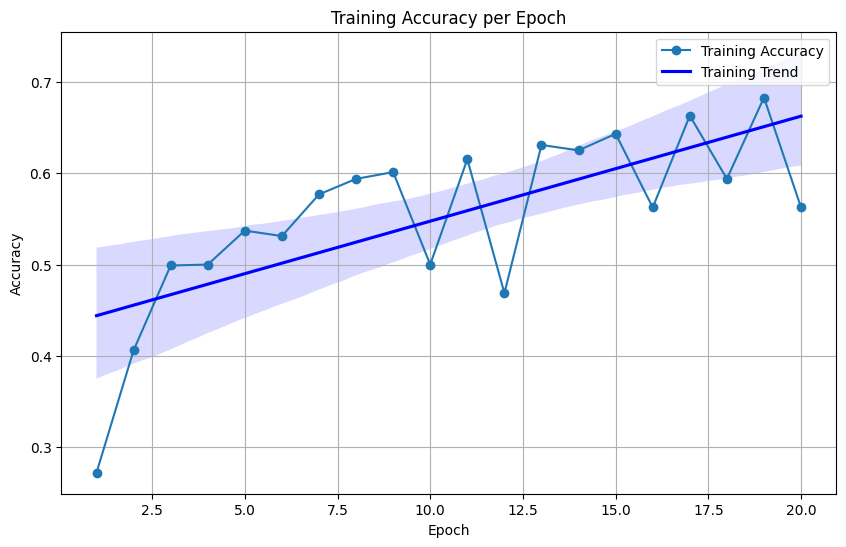

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(data['Epoch'], data['Training Accuracy'], label='Training Accuracy', marker='o')
sns.regplot(x=np.array(data['Epoch']), y=data['Training Accuracy'], scatter=False, color='blue', label='Training Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()

And then evaluate the model’s performance by generating a classification report, using metrics like accuracy, precision, recall, support, and f-1 score.

In [ ]:
actual_classes = results_with_calories['ClassName_Actual']
predicted_classes = results_with_calories['Predicted_ClassName']
accuracy = accuracy_score(actual_classes, predicted_classes)
precision = precision_score(actual_classes, predicted_classes, average='weighted')
recall = recall_score(actual_classes, predicted_classes, average='weighted')
f1 = f1_score(actual_classes, predicted_classes, average='weighted')
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
report = classification_report(actual_classes, predicted_classes)
print("\nClassification Report:\n", report)

Accuracy: 0.5224839400428265
Precision: 0.516899527231433
Recall: 0.5224839400428265
F1-Score: 0.5033506571074918

Classification Report:
                                    precision    recall  f1-score   support

                          almonds       0.50      0.25      0.33         4
                            apple       1.00      0.80      0.89        10
                          avocado       0.75      0.75      0.75         4
                           banana       0.67      0.89      0.76         9
                             beer       1.00      0.75      0.86         4
                         biscuits       1.00      0.33      0.50         3
           boisson-au-glucose-50g       1.00      0.25      0.40         4
         bread-french-white-flour       0.00      0.00      0.00         3
                  bread-sourdough       0.00      0.00      0.00         3
                      bread-white       0.48      0.53      0.51        30
                bread-whole-wheat  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

#### B. The Results

Now we can evaluate our results!

Let's start by merging the true class names of each test image with the other results.

In [ ]:
results_with_actual = pd.merge(results, test_data[['ImageId', 'ClassName']], on='ImageId')
results_with_calories = pd.merge(results_with_actual, calorie_data, left_on='Predicted_ClassName', right_on='ClassName', suffixes=('_Actual', '_Predicted'))
print(results_with_calories[['ImageId', 'ClassName_Actual', 'Predicted_ClassName', 'Calories_per_Serving']])

            ImageId            ClassName_Actual         Predicted_ClassName  \
0    741ff5d545.jpg        coffee-with-caffeine        coffee-with-caffeine   
1    abda981011.jpg      boisson-au-glucose-50g      boisson-au-glucose-50g   
2    634acec650.jpg                    wine-red                    wine-red   
3    1f13bf8e21.jpg                       apple                       apple   
4    b14ed11b23.jpg                      butter             bread-wholemeal   
..              ...                         ...                         ...   
462  4d7a4906e0.jpg                       water                       water   
463  4f224e4b21.jpg                       water                       water   
464  8242111c5c.jpg                      carrot                french-beans   
465  6789f065c4.jpg                       water                       water   
466  6062592d95.jpg  white-coffee-with-caffeine  white-coffee-with-caffeine   

     Calories_per_Serving  
0                      

We can also visualize some of these images with their real and predicted classes, along with the number of calories for the food.

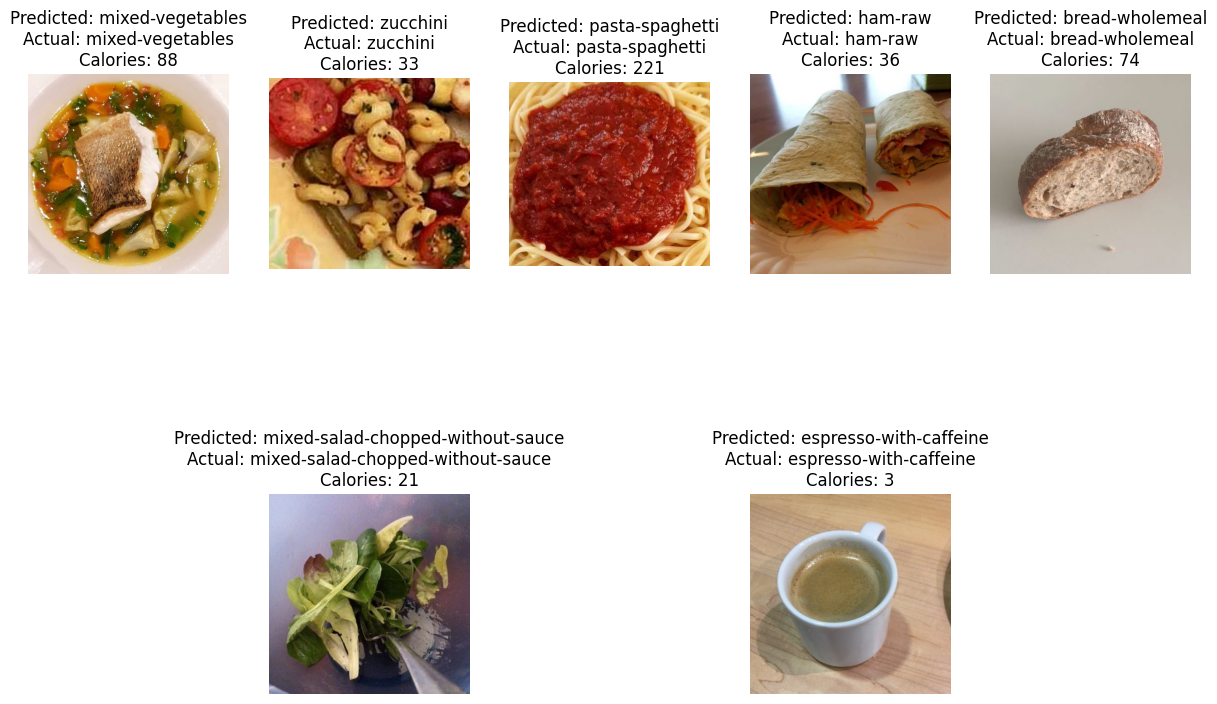

In [ ]:
random_samples = random.sample(range(len(results_with_calories)), 10)
random_results = results_with_calories.iloc[random_samples]
plt.figure(figsize=(15, 10))
for index, row in random_results.iterrows():
    image_path = os.path.join(testing_images_folder, row['ImageId'])
    image = Image.open(image_path)
    plt.subplot(2, 5, index % 10 + 1)
    plt.imshow(image)
    plt.title(f"Predicted: {row['Predicted_ClassName']}\nActual: {row['ClassName_Actual']}\nCalories: {row['Calories_per_Serving']}")
    plt.axis('off')
plt.show()

With the actual vs. predicted class information, we can create a confusion matrix to better visualize the results.

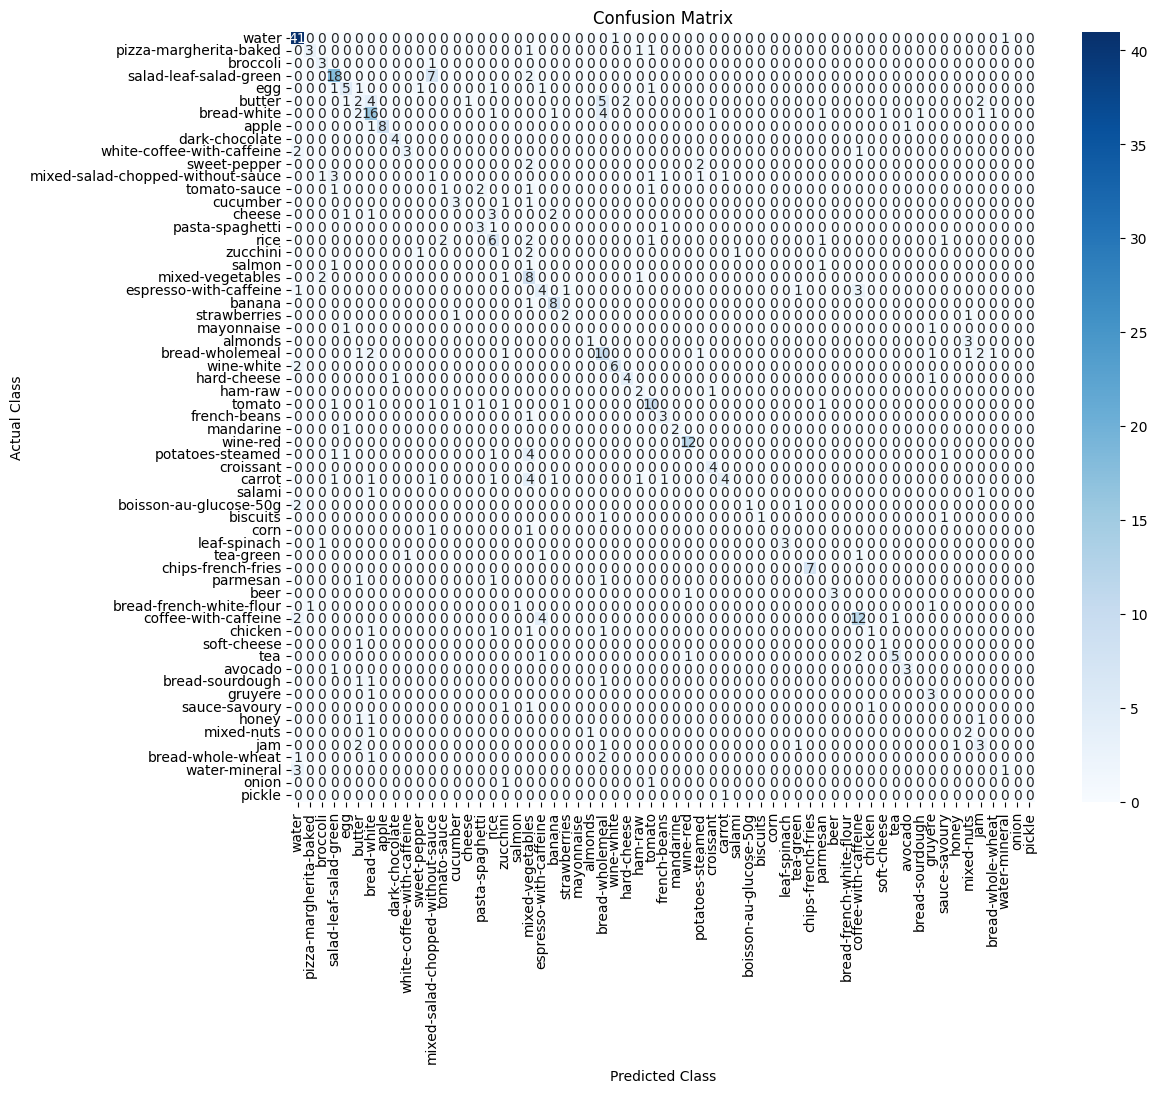

In [ ]:
actual_class_names = results_with_calories['ClassName_Actual']
predicted_class_names = results_with_calories['Predicted_ClassName']
cm = confusion_matrix(actual_class_names, predicted_class_names, labels=calorie_data['ClassName'].unique())
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=calorie_data['ClassName'].unique(), yticklabels=calorie_data['ClassName'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

That is a large confusion matrix!

Let's simplify things a little and only look at a confusion matrix for the top 10 misclassified classes.

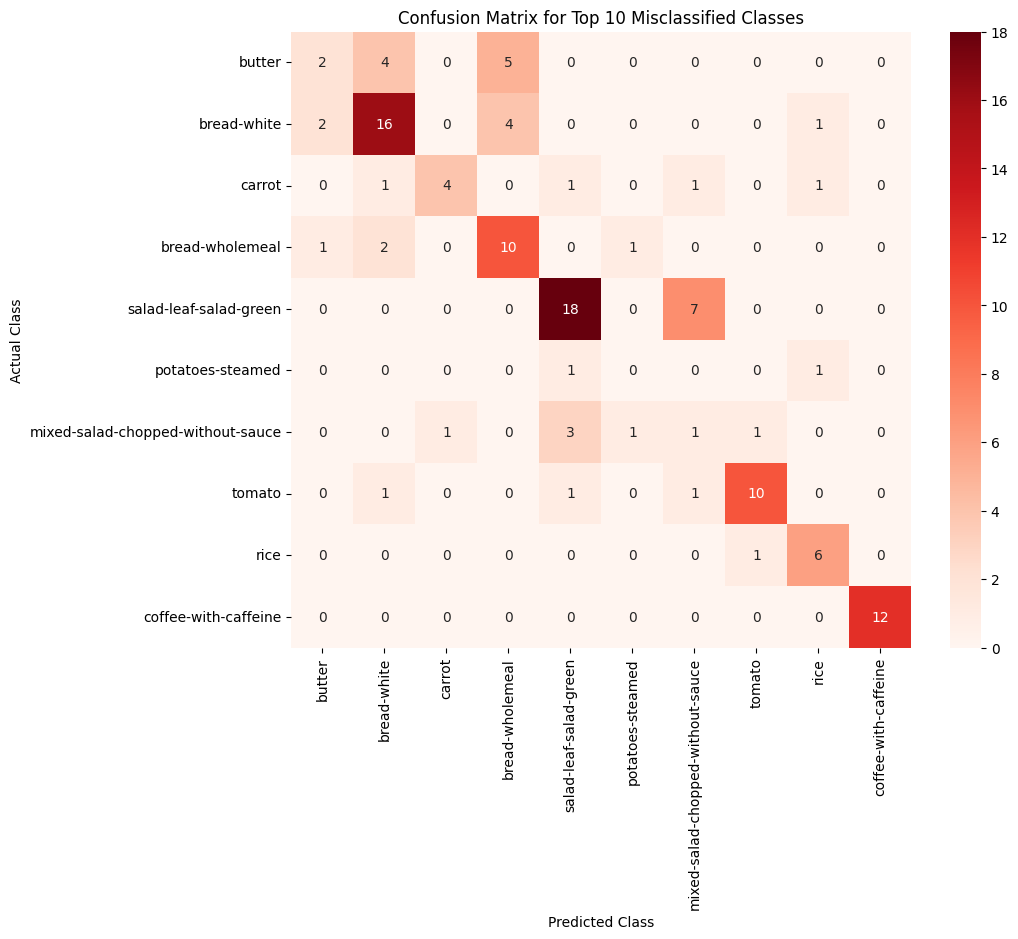

In [ ]:
misclassified = actual_class_names[actual_class_names != predicted_class_names]
top_10_misclassified = misclassified.value_counts().nlargest(10).index
filtered_actual_misclassified = actual_class_names[actual_class_names.isin(top_10_misclassified)]
filtered_predicted_misclassified = predicted_class_names[actual_class_names.isin(top_10_misclassified)]
cm_misclassified = confusion_matrix(filtered_actual_misclassified, filtered_predicted_misclassified, labels=top_10_misclassified)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_misclassified, annot=True, fmt='d', cmap='Reds', xticklabels=top_10_misclassified, yticklabels=top_10_misclassified)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title(f'Confusion Matrix for Top {10} Misclassified Classes')
plt.show()

And that concludes the code component of our Nutrivision project!